<Axes: title={'center': 'Model accuracy'}, xlabel='Model'>

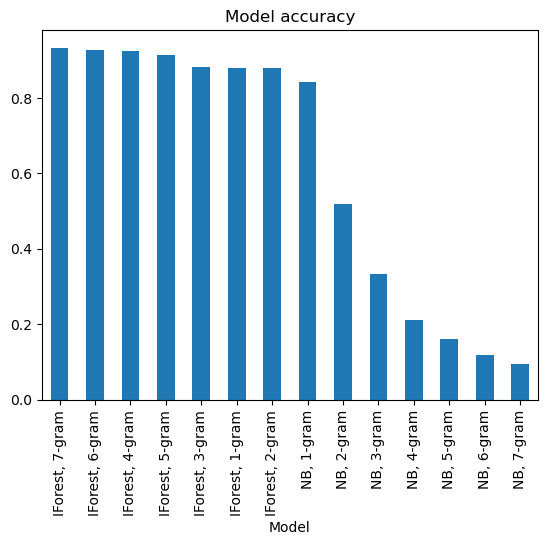

In [4]:
# V1
import log_reader as lr
from preprocessors.preprocessor import Preprocessor
from train_models import load_model
import os
import pandas as pd

# Read all logs from logs directory
df = lr.read_all_logs(version=1)
preprocessor = Preprocessor.get(version=1)
df = preprocessor.preprocess(df)

# Load models
models_dir = os.path.join(os.getcwd(), 'models/trained/v1')
if not os.path.exists(models_dir):
    raise FileNotFoundError('No models found, run train_models.py --version 1 first')

models = [load_model(os.path.join(models_dir, model)) for model in os.listdir(models_dir)]
model_score = {}
for model in models:
    score = model.get_score(df['syscall'], df['malicious'])
    model_score[model] = score

# Create graph of accuracy per model
model_score = pd.DataFrame(list(model_score.items()), columns=['Model', 'Score'])
model_score = model_score.sort_values(by='Score', ascending=False)
model_score.plot(kind='bar', x='Model', y='Score', legend=False, title='Model accuracy')



<Axes: title={'center': 'Model accuracy'}, xlabel='Model'>

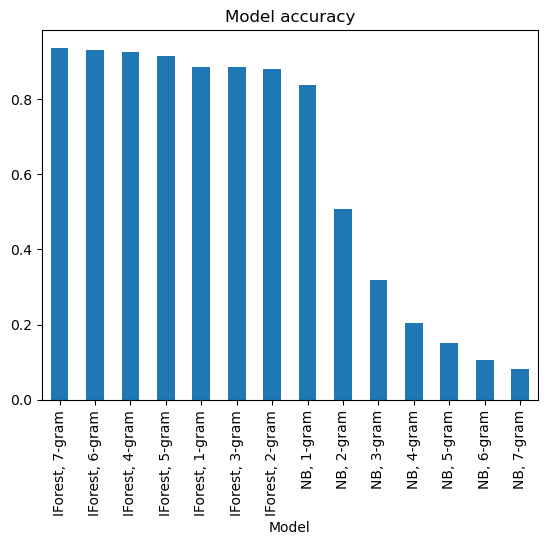

In [5]:
# V2
df = lr.read_all_logs(version=2)
preprocessor = Preprocessor.get(version=1)
df = preprocessor.preprocess(df)

# Load models
models_dir = os.path.join(os.getcwd(), 'models/trained/v1')
models = [load_model(os.path.join(models_dir, model)) for model in os.listdir(models_dir)]

model_score = {}
for model in models:
    score = model.get_score(df['syscall'], df['malicious'])
    model_score[model] = score

# Create graph of accuracy per model
model_score = pd.DataFrame(list(model_score.items()), columns=['Model', 'Score'])
model_score = model_score.sort_values(by='Score', ascending=False)
model_score.plot(kind='bar', x='Model', y='Score', legend=False, title='Model accuracy')